# 6. 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷
## 규제 선형 모델의 개요

#### 최적 비용 함수 = 학습 데이터의 잔차 오류 값을 최소로 하는 RSS 최소화 방법 + 과적합을 방지하기 위해 회귀 계수 값이 커지지 않도록 하는 방법
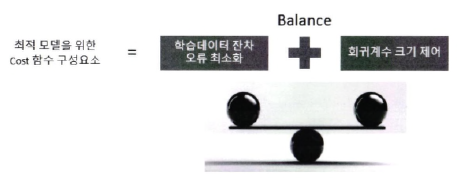
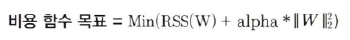
#### alpha는 학습 데이터 적합 정도와 회귀 계수 값의 크기 제어를 수행하는 튜닝 파라미터이다.
#### alpha 값을 크게 하면 비용 함수는 회귀 계수 W의 값을 작게 해 과적합을 개선할 수 있고, alpha 값을 작게 하면 회귀 계수 W의 값이 커져도 어느 정도 상쇄 가능하여 학습 데이터 적합을 더 개선 가능하다.
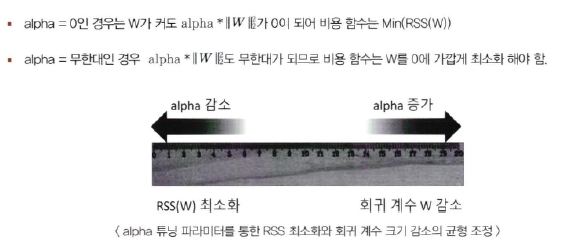

#### 이처럼 비용 함수에 alpha 값으로 패널티를 부여해 회귀 계수 값의 크기를 감소시켜 과적합을 개선하는 방식을 규제(Regulariztion)이라 한다. - L2 방식, L1 방식
#### L2 방식 : W의 제곱에 대해 패널티를 부여하는 방식 - 릿지(Ridge) 회귀
#### L1 방식 : W의 절대값에 대해 패널티를 부여하는 방식 - 라쏘(Lasso) 회귀 - 영향력이 크지 않은 회귀 계수 값을 0으로 변환

## 릿지 회귀
#### 사이킷런의 Ridge 클래스로 구현하고, 주요 생성 파라미터는 alpha이며 이는 L2 규제 계수에 해당한다.
#### *boston 데이터셋은 현재 다운로드가 되지 않음! 저자 코드 참고

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_boston
import pandas as pd

boston = load_boston()

bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)
bostonDF['PRICE'] = boston.target

y_target = bostonDF['PRICE']
x_data = bostonDF.drop(['PRICE'], axis=1, inplace=True)

ridge = Ridge(alpha = 10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 3))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores,3))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

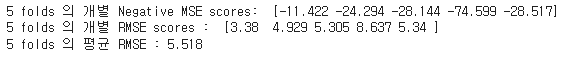
#### 릿지 5개 폴드 세트의 평균 RMSE가 5.518 - LinearRegression의 평균 RMSE는 5.829 : 릿지가 더 뛰어난 예측 성능

In [ ]:
alphas = [0, 0.1, 1, 10, 100]

for alpha in alphas:
    ridge = Ridge(alpha = alpha)
    
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0} 일 때 5 folds 의 평균 RMSE : {1:.3f} '.format(alpha,avg_rmse))

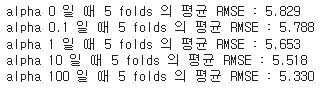
#### alpha가 100일 때 평균 RMSE가 가장 좋다

In [ ]:
# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성  
fig , axs = plt.subplots(figsize=(18,6) , nrows=1 , ncols=5)
# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성  
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos , alpha in enumerate(alphas) :
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_data , y_target)
    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가.  
    coeff = pd.Series(data=ridge.coef_ , index=X_data.columns )
    colname='alpha:'+str(alpha)
    coeff_df[colname] = coeff
    # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수값이 높은 순으로 표현
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3,6)
    sns.barplot(x=coeff.values , y=coeff.index, ax=axs[pos])

# for 문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시
plt.show()

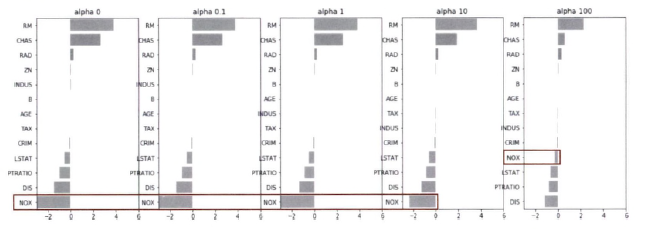
#### alpha 값을 계속 증가시킬수록 회귀 계수 값은 지속적으로 작아진다. (특히 NOX 피처)

In [ ]:
ridge_alphas = [0, 0.1, 1, 10, 100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

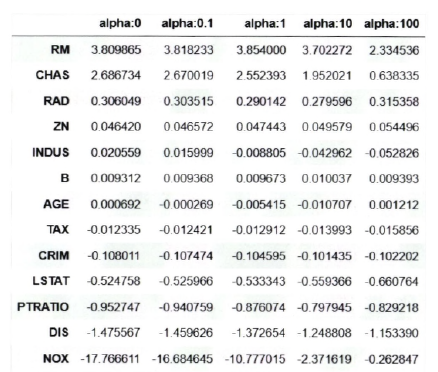
#### alpha 값이 증가하면서 회귀 계수가 지속적으로 작아지고 있다. 하지만, 릿지 회귀의 경우는 회귀 계수를 0으로 만들지는 않는다.

## 라쏘 회귀
#### W의 절대값에 패널티를 부여하는 L1 규제를 선형 회귀에 적용한 것
#### L2 규제가 회귀 계수의 크기를 감소시키는 데 반해, L1 규제는 불필요한 회귀 계수를 급격하게 감소시켜 0으로 만들고 제거(적절한 피처만 회귀에 포함시키는 특성)

In [ ]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환 
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, 
                        verbose=True, return_coeff=True):
    coeff_df = pd.DataFrame()
    if verbose : print('####### ', model_name , '#######')
    for param in params:
        if model_name =='Ridge': model = Ridge(alpha=param)
        elif model_name =='Lasso': model = Lasso(alpha=param)
        elif model_name =='ElasticNet': model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n, 
                                             y_target_n, scoring="neg_mean_squared_error", cv = 5)
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f} '.format(param, avg_rmse))
        # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
        
        model.fit(X_data_n , y_target_n)
        if return_coeff:
            # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가. 
            coeff = pd.Series(data=model.coef_ , index=X_data_n.columns )
            colname='alpha:'+str(param)
            coeff_df[colname] = coeff
    
    return coeff_df

In [ ]:
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_data, y_target_n=y_target)

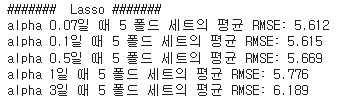
#### alpha가 0.07일 때 5.618로 가장 좋은 평균 RMSE

In [ ]:
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

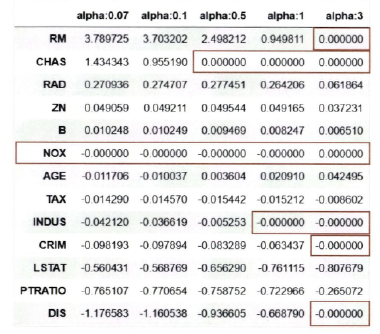
#### alpha의 크기가 증가함에 따라 일부 피처의 회귀 계수는 아예 0으로 바뀌고 있다.
#### 즉, 회귀 계수가 0인 피처는 회귀 식에서 제외되면서 피처 선택의 효과를 얻는다

## 엘라스틱넷 회귀
#### L2 규제와 L1 규제를 결합한 회귀이다. 그래서 비용 함수의 목표는 아래의 식을 최소화 하는 W를 찾는 것이다.

#### 엘라스틱넷은 라쏘 회귀로 인해 alpha 값에 따라 회귀 계수의 값이 급격하게 변동할 수 있는데, 이를 완화하고자 L2 규제를 추가했다.
#### 단점으로는 L1 + L2 규제를 모두 적용한 나머지 수행시간이 상대적으로 오래걸린다.

#### 사이킷런의 ElasticNet 클래스를 통해 구현하는데, 주요 생성 파라미터는 alpha와 l1_ratio이다.
#### 여기서 alpha는 Ridge와 Lasso 클래스의 alpha와는 다르다.
#### 엘라스틱 넷의 규제는 a * L1 + b * L2로 정의될 수 있는데, a는 L1 규제의 alpha 값, b는 L2 규제의 alpha 값이므로 엘라스틱 넷의 alpha 파라미터는 a + b 값이다.
#### l1_ratio 파라미터 값은 a / ( a + b )이다.

In [ ]:
# 위에서 작성한 get_linear_reg_eval()함수 사용
# l1_ratio는 0.7로 고정
elastic_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet', params=elastic_alphas, x_data_n=X_data, y_target_n=y_target)

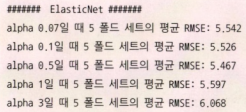

In [ ]:
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

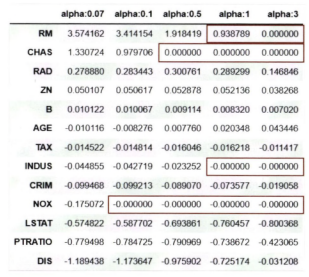
#### alpha가 0.5일 때, RMSE가 가장 좋은 예측 성능을 보여주고 있다.
#### 각각의 알고리즘에서 하이퍼 파라미터를 변경해 최적의 예측 성능을 찾아야 한다.
#### 하지만, 선형 회귀의 경우 먼저 데이터 분포도의 정규화와 인코딩 방법도 매우 중요하다.

## 선형 회귀 모델을 위한 데이터 변환
#### 선형 회귀 모델은 피처값과 타깃값의 분포가 정규 분포 형태를 매우 선호한다.
#### 따라서 선형 회귀 모델을 적용하기 전에 데이터에 대한 스케일링/정규화 작업이 선행된다. -> 중요 피처들이나 타깃값의 분포도가 심하게 왜곡되었을 때 수행

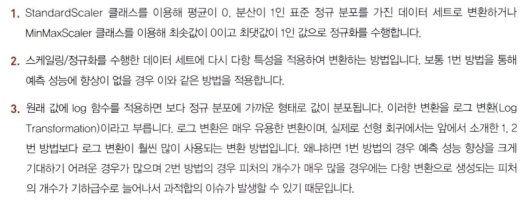

#### 타깃값은 일반적으로 로그 변환 적용한다 -> 원복 복원 작업 수월

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# method는 표준 정규 분포 변환(Standard), 최대값/최소값 정규화(MinMax), 로그변환(Log) 결정
# p_degree는 다향식 특성을 추가할 때 적용. p_degree는 2이상 부여하지 않음. 
def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data

    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree, 
                                         include_bias=False).fit_transform(scaled_data)
    
    return scaled_data

#### 피처 데이터 변환 방법
#### 1. 아무런 변환을 하지 않은 원본 데이터 : (None, None)
#### 2. 표준 정규 분포 : (standard, None)
#### 3. 표준 정규 분포(2차 다항식 변환) : (Standard, 2)
#### 4. 최솟값/최대값 정규화 : (MinMax, 2)
#### 5. 최솟값/최대값 정규화(2차 다항식 변환) : (Log, None) - 로그 변환

In [ ]:
alphas = [0.1, 1, 10, 100]

scale_methods = [(None, None), ('Standard', None), ('Standard', 2), ('MinMax', None),
                ('MinMax', None), ('MinMax', 2)]
for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale.method[1],
                                   input_data=X_data)
    print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval('Ridge', params=alphas, X_data_n=X_data_scaled, 
                        y_target_n=y_target, verbose=False, return_coeff=False)

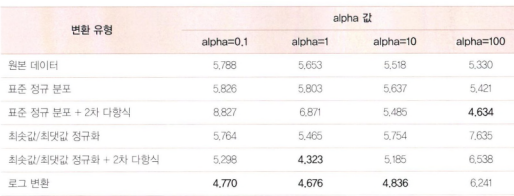
#### 2차 다항식 변환과 로그 변환의 경우 성능이 개선이 되었다.
#### 하지만, 2차 다항식의 경우 피처의 개수가 많을 경우 적용하기 힘들고, 데이터 건수가 많아지만 계산에 많은 시간이 소모된다.
#### 그래서, 로그 변환을 적용한다(데이터 값의 분포가 심하게 왜곡되어 있을 경우)